In [725]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

class Household(Agent):
    def __init__(self, unique_id, model, disposable_income, dwelling, inability=False):
        super().__init__(unique_id, model)
        self.disposable_income = disposable_income
        self.dwelling = dwelling
        self.inability = inability
        self.savings = 0  # savings is initialized as 0
        self.arrears = 0

    @property
    def energy_cost(self):
        """Calculate and return the current energy cost for the agent."""
        return self.model.energy_price * (self.dwelling)
        
    def step(self):
        """Update the agent's savings in a step."""
        # Calculate energy costs
        energy_costs = self.energy_cost

        # Check if the agent is in arrears
        if energy_costs > self.disposable_income * 0.3:  # now considering arrears if energy cost exceeds 60% of disposable income
            self.arrears += energy_costs
        else:
            self.savings += self.disposable_income - energy_costs

        # If the agent has arrears
        if self.arrears > 0:
            if self.savings >= self.arrears:  # and if savings can cover it
                self.savings -= self.arrears
                self.arrears = 0
            else:  # if savings cannot cover it
                self.arrears = self.arrears - self.savings  # set arrears to remaining amount
                self.savings = 0

        self.inability = self.energy_cost > self.disposable_income * 0.1  # agent is in inability state if energy costs exceed 10% of income

        # Update disposable income based on growth rate
        growth_rate = np.random.uniform(self.model.growth_boundaries[0], self.model.growth_boundaries[1])
        self.disposable_income *= (1 + growth_rate)


class Country(Model):
    
    @classmethod
    def calculate_gini(cls, incomes):
        incomes = np.sort(incomes)
        n = len(incomes)
        index = np.arange(1, n + 1)
        return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))

    @classmethod
    def generate_income_distribution(cls, num_people, median_income, gini_target, lower_bound):
        alpha = (gini_target + 1) / (2 - gini_target)
        for _ in range(10000):
            incomes = stats.gamma.rvs(alpha, scale=median_income/alpha, size=num_people)
            incomes = np.clip(incomes, lower_bound, None)  # None means there is no upper bound
            gini_current = cls.calculate_gini(incomes)
            if np.isclose(gini_current, gini_target, atol=0.01):
                return incomes
            elif gini_current < gini_target:
                alpha *= 0.9
            else:
                alpha *= 1.1

        raise Exception(f"Failed to reach target Gini coefficient in 1000 iterations. Current Gini: {gini_current}")
    
    @staticmethod
    def assign_inability(agents, inability_start):
        """
        Assigns the inability to the agents.
        """
        agents.sort(key=lambda x: x.disposable_income)

        num_agents = len(agents)
        num_unable = int(inability_start * num_agents)
        inability_per_quintile = np.array([2, 1.6, 1.2, 0.8, 0])
        inability_per_quintile *= num_unable / np.sum(inability_per_quintile)
        inability_per_quintile = inability_per_quintile.astype(int)

        assigned_unable = 0
        for i in range(5):  # For each quintile
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = agents[start:end]
            num_unable_quintile = min(inability_per_quintile[i], len(quintile))
            unable_agents = np.random.choice(quintile, num_unable_quintile, replace=False)
            for agent in unable_agents:
                agent.inability = True
            assigned_unable += num_unable_quintile

        # Assign remaining inability if any
        i = 0
        while assigned_unable < num_unable:
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = [agent for agent in agents[start:end] if not agent.inability]
            if quintile:
                agent = np.random.choice(quintile)
                agent.inability = True
                assigned_unable += 1
            else:
                i += 1


    @staticmethod
    def assign_dwelling(agents, energy_price):
        """
        Assigns the dwelling to the agents.
        """
        buffer = 0.02  # 2% buffer or margin
        for agent in agents:
            min_dwelling, max_dwelling = 500, 2000
            if agent.inability:
                min_dwelling = max(min_dwelling, int(np.ceil((agent.disposable_income * (0.1 + buffer)) / energy_price)))
            else:
                max_dwelling = min(max_dwelling, int((agent.disposable_income * (0.1 - buffer)) / energy_price))

            # Generate a list of feasible dwelling values
            feasible_dwelling = list(range(min_dwelling, max_dwelling + 1))

            # If the list is not empty, select a random dwelling from the list
            if feasible_dwelling:
                agent.dwelling = np.random.choice(feasible_dwelling)
            else:
                agent.dwelling = min_dwelling  # fallback to the min_dwelling if no other options



    def __init__(self, N, median_income, min_disposal, gini_target, inability_target, growth_boundaries, prices, shares_p, growth_rate_lower_bound, growth_rate_upper_bound):
        self.num_agents = N
        self.median_income = median_income
        self.min_disposal = min_disposal
        self.gini_target = gini_target
        self.inability_target = inability_target
        self.growth_boundaries = growth_boundaries
        self.prices = prices
        self.shares_p = shares_p
        self.growth_rate_lower_bound = growth_rate_lower_bound
        self.growth_rate_upper_bound = growth_rate_upper_bound
        # Other initialization code...
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
        agent_reporters={"Dwelling": "dwelling", 
                        "Income": "disposable_income",
                        "Inability": "inability",
                        "Savings":"savings",
                        "Arrears":"arrears",
                        "EnergyCost": "energy_cost"},
        model_reporters = {
                        "Inability Over Time": lambda model: sum(agent.inability for agent in model.schedule.agents) / model.num_agents,
                        "Arrears Over Time": lambda model: sum(agent.arrears for agent in model.schedule.agents) / model.num_agents,
                        "Energy Price": lambda model: model.energy_price,
                        "Initial Energy Price": lambda model: model.initial_energy_price
                        })

        # Generate disposable incomes and assign dwelling and technology
        incomes = self.generate_income_distribution(self.num_agents, self.median_income, self.gini_target, self.min_disposal)

        self.initial_energy_price = np.dot(self.prices, self.shares_p)

 
        # Create agents
        agents = []
        for i in range(self.num_agents):
            a = Household(i, self, disposable_income=incomes[i], dwelling=0, inability=False)
            agents.append(a)

        
        self.assign_inability(agents, self.inability_target)
        self.assign_dwelling(agents, self.energy_price)

        # Add agents to the model
        for a in agents:
            self.schedule.add(a)

    @property
    def energy_price(self):
        """Calculate and return the current energy price."""
        return np.dot(self.prices, self.shares_p)

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)  # Collect data before updating the prices

        # Update prices based on unique growth rates
        growth_rates = np.random.uniform(self.growth_rate_lower_bound, self.growth_rate_upper_bound)
        self.prices = np.maximum(0, self.prices * (1 + growth_rates))

        self.schedule.step()

In [726]:
# population, median_income, min_disposal, gini_target, inability_target, growth_boundaries:[], prices, shares_p, growth_rate_lower_bound, growth_rate_upper_bound

In [727]:

model = Country(1000, 1700, 900, 0.30, 0.2, [-0.02,0.02], np.array([0.2, 0.06]), np.array([0.5, 0.5]), np.array([-0.01, -0.01]), np.array([0.01, 0.01]) )

 
for i in range(84):
    model.step()


agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()


In [728]:
agent_data

Dwelling        Income  Inability        Savings  Arrears  \
Step AgentID                                                              
0    5            1140    900.000000       True       0.000000      0.0   
     10            522    900.000000      False       0.000000      0.0   
     17            522    900.000000      False       0.000000      0.0   
     19           1435    900.000000       True       0.000000      0.0   
     22            528    900.000000      False       0.000000      0.0   
...                ...           ...        ...            ...      ...   
83   367          1802   6606.011489      False  566873.205286      0.0   
     769          1792   7528.470705      False  603355.291974      0.0   
     151           619   7272.711285      False  598542.518129      0.0   
     920          1942   8409.707398      False  720538.405783      0.0   
     187          1587  10593.890723      False  744964.099894      0.0   

              EnergyCost  
Step AgentID              
0    5        148.200000  
     10        67.860000  
     17        67.860000  
     19       186.550000  
     22        68.640000  
...                  ...  
83   367      226.562499  
     769      225.305215  
     151       77.825853  
     920      244.164469  
     187      199.530902  

[84000 rows x 6 columns]

In [730]:
import plotly.graph_objects as go

# Assume that `model` is the instance of your model
model_df = model.datacollector.get_model_vars_dataframe()

# Create a line plot
fig = go.Figure(data=go.Scatter(x=model_df.index, y=model_df['Inability Over Time'], mode='lines'))

# Set labels and title
fig.update_layout(title='Average inability over time', xaxis_title='Time (steps)', yaxis_title='Average inability')

# Show plot
fig.show()


In [731]:
agent_data = model.datacollector.get_agent_vars_dataframe()
arrears_data = agent_data['Arrears']


In [732]:
import plotly.graph_objects as go

# Create a dataframe from the agent data
model_df = model.datacollector.get_model_vars_dataframe()

# Create a line plot for 'Arrears Over Time'
fig = go.Figure(data=go.Scatter(x=model_df.index, y=model_df['Arrears Over Time'], mode='lines'))

# Set labels and title
fig.update_layout(title='Arrears Over Time', xaxis_title='Time (steps)', yaxis_title='Arrears')

# Show plot
fig.show()


In [733]:
model_df['Arrears Over Time']

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
        ...   
79    7.864383
80    8.114018
81    8.363718
82    8.612473
83    8.862673
Name: Arrears Over Time, Length: 84, dtype: float64

In [734]:
# Fetch agent-level data
agent_df = model.datacollector.get_agent_vars_dataframe()

# Get data for steps 44 to 46
steps_44_to_46 = agent_df.xs(slice(44, 46), level="Step")

steps_44_to_46


,Dwelling,Income,Inability,Savings,Arrears,EnergyCost
AgentID,,,,,,
5,1140,914.370128,True,33473.920198,0.0,144.538456
10,522,872.406616,False,34945.458423,0.0,66.183398
17,522,930.254042,False,37910.597005,0.0,66.183398
19,1435,885.729663,True,32975.951715,0.0,181.940951
22,528,913.960851,False,36799.909979,0.0,66.944127
...,...,...,...,...,...,...
367,1802,7040.094883,False,319523.330914,0.0,230.003562
769,1792,7356.766379,False,327975.742159,0.0,228.727183
151,619,7305.654553,False,336267.128222,0.0,79.007883


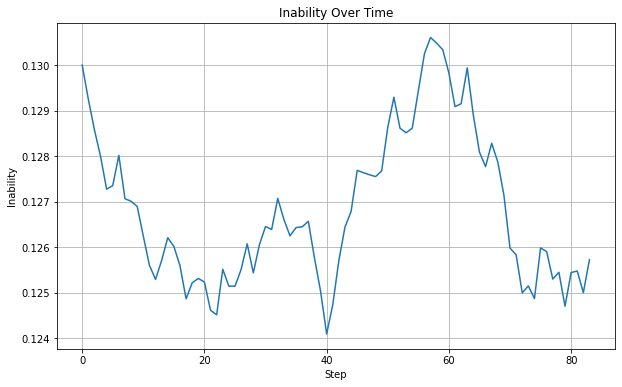

In [736]:
# After running the model
model_data = model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(10, 6))
plt.plot(model_data['Energy Price'])
plt.xlabel('Step')
plt.ylabel('Inability')
plt.title('Inability Over Time')
plt.grid(True)
plt.show()

In [737]:
model_data['Inability Over Time']

0     0.200
1     0.200
2     0.200
3     0.200
4     0.200
      ...  
79    0.199
80    0.200
81    0.202
82    0.201
83    0.201
Name: Inability Over Time, Length: 84, dtype: float64

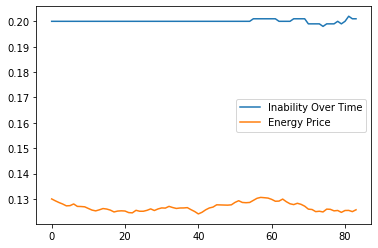

In [738]:
model_data[["Inability Over Time", "Energy Price"]].plot()
plt.show()


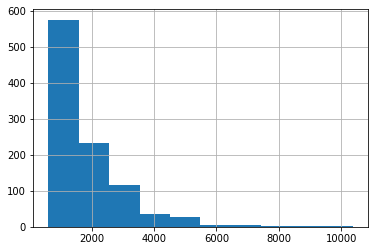

In [739]:
agent_data.xs(80, level="Step")["Income"].hist()
plt.show()
